## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_diagonal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/diagonal/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


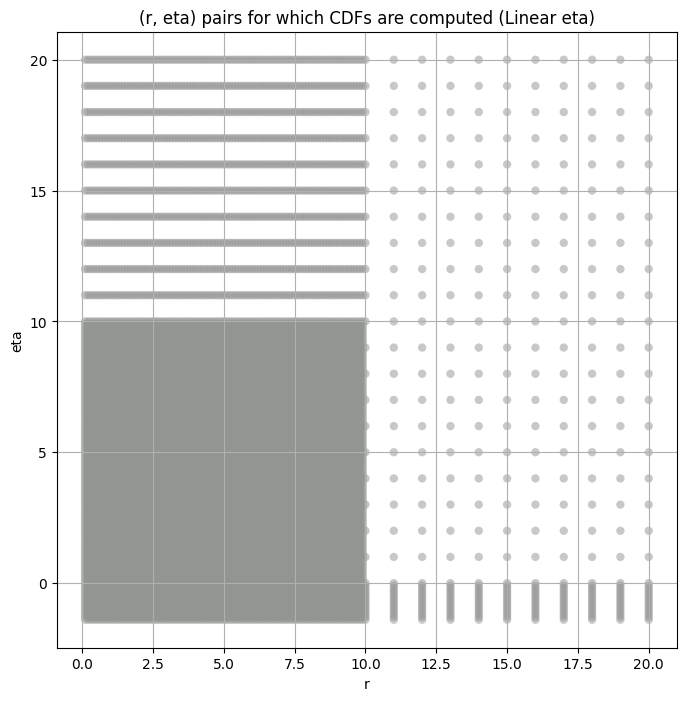

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1270.457600  1168.367300  1376.895000   0.489977    0.119493   
3       299.618200   284.338960   315.560900   1.992060    1.628158   
4        63.174885    58.869780    67.908690   5.602782    3.600154   
5        12.390842    11.438591    13.486277   8.176788    5.416881   
6         2.428821     2.212382     2.730339  13.770252    7.058678   
7         0.517790     0.464621     0.626408  29.275566    8.197229   
8         0.152339     0.134369     0.196486  49.609196    9.834152   
9         0.046734     0.040591     0.059938  54.144787   13.522397   

       kurt_upper  total_samples  
layer                             
2        0.913066         2446.0  
3        2.431081         9784.0  
4        9.362343        39136.0  
5       19.982847       156544.0  
6       52.622623       626176.0  
7      170.895340      2504704.0  
8      280.199700     10018816.0  
9      272.314400     40075264.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      1270.457600    1270.457642     1084.486694      971.843140   
3       299.618200     299.618195      276.496521      261.092621   
4        63.174885      63.174885       59.846657       58.010952   
5        12.390842      12.390842       11.990485       11.750929   
6         2.428821       2.428821        2.326704        2.273115   
7         0.517790       0.517790        0.489417        0.476919   
8         0.152339       0.152339        0.142097        0.138037   
9         0.046734       0.046734        0.043143        0.041646   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2          882.140015       804.326111       679.048096       573.159729   
3          248.355927       237.376953       218.275879       202.522385   
4           56.540924        55.262501        53.087147        51.219002   
5           11.553584        11.378798        11.075451        10.812894   
6            2.228546         2.189694         2.122475         2.064299   
7            0.466624         0.457679         0.442265         0.429055   
8            0.134725         0.131846         0.126908         0.122694   
9            0.040434         0.039388         0.037606         0.036098   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           484.564240       407.135620       341.630798       202.830261  
3           189.089081       177.314758       166.666275       140.156921  
4            49.571201        48.076622        46.706715        43.079235  
5            10.576421        10.360840        10.160164         9.632683  
6             2.012481         1.965419         1.922035         1.808124  
7             0.417339         0.406701         0.396937         0.371540  
8             0.118963         0.115599         0.112521         0.104553  
9             0.034776         0.033593         0.032518         0.029765

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.015839126740195497 1270.4576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.026688929439087405 1084.4867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.036939631313041565 971.84314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.046784972898399224 882.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0562992318750003 804.3261


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.0734128134526374 679.0481


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.08937999289462462 573.1597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.10770696155179138 484.56424


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.12702047130496275 407.13562


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.1457320122611211 341.6308


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.19289951613884515 202.83026
Number of samples: 2446, Without approximation : 2446.0


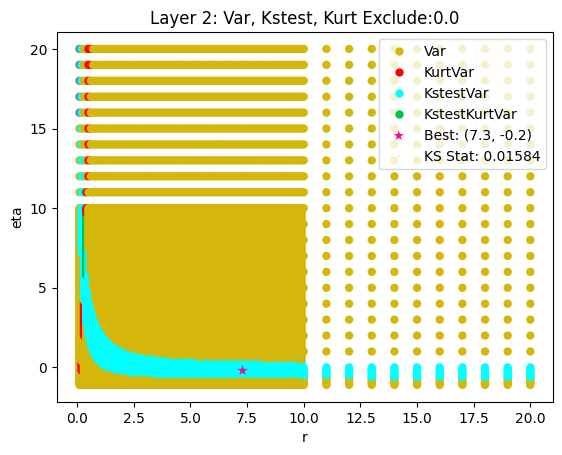

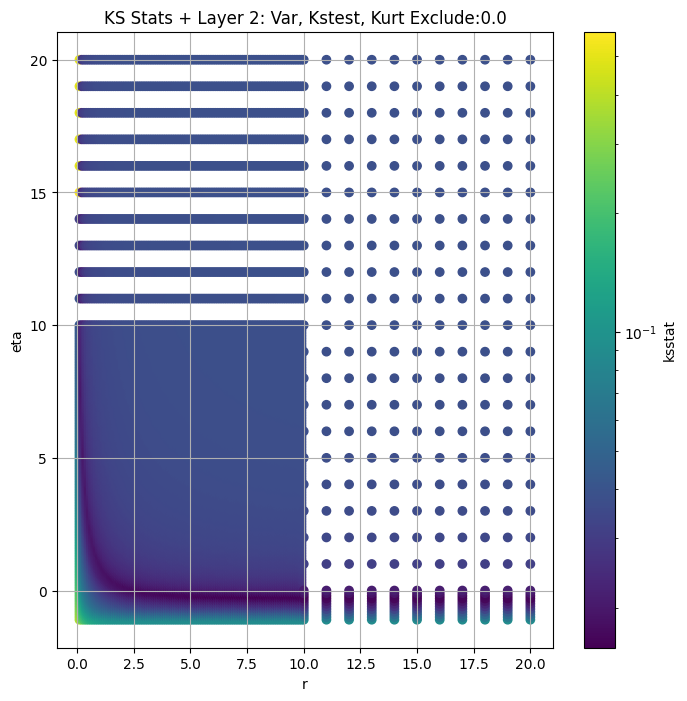

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.0080098344083544 299.6182


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.009391723868046653 276.49652


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.010907583163122236 261.09262


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.014116922778930063 248.35593


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.017326529194018225 237.37695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.023301762870652887 218.27588


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.029314654967316445 202.52238


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.03509363668274934 189.08908


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.040190799566215074 177.31476


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.04520247893449847 166.66628


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.058744538332074936 140.15692
Number of samples: 9784, Without approximation : 9784.0


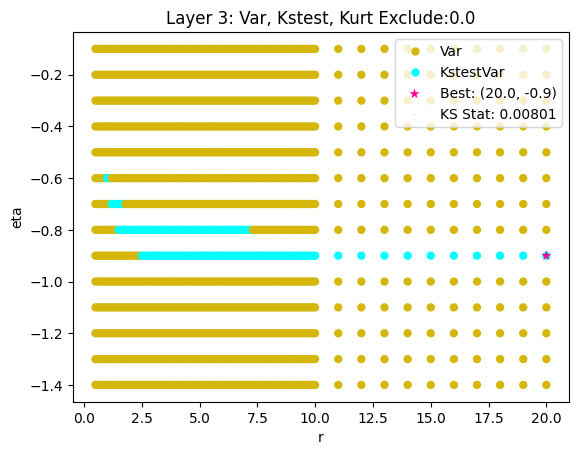

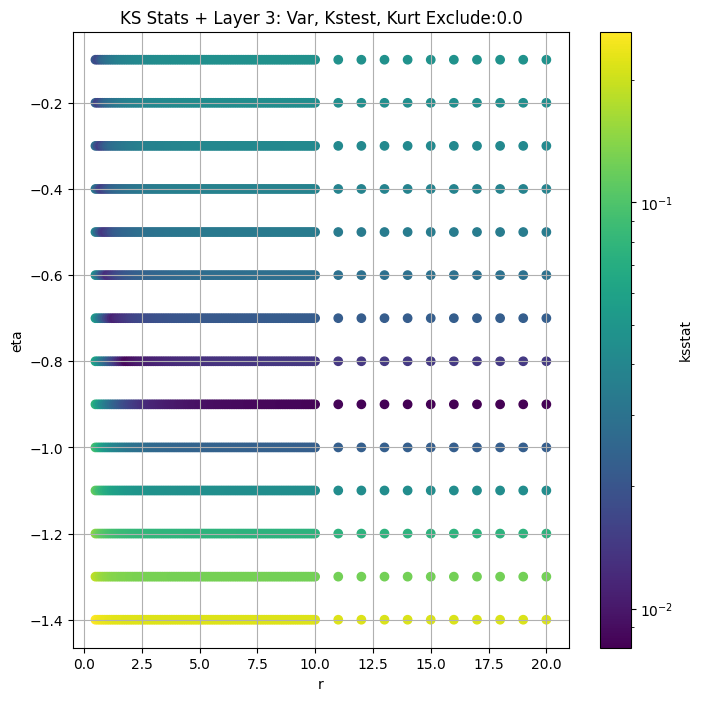

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.0038787432735075678 63.174885


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.005106548620021023 59.846657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.005667397822627707 58.010952


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.005990334397542152 56.540924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.006833902178856155 55.2625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.00826138684822908 53.087147


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.009485096009399396 51.219


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.01116287212727829 49.5712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.01271631482878477 48.076622


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.014153192831420025 46.706715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.018973498031901403 43.079235
Number of samples: 39136, Without approximation : 39136.0


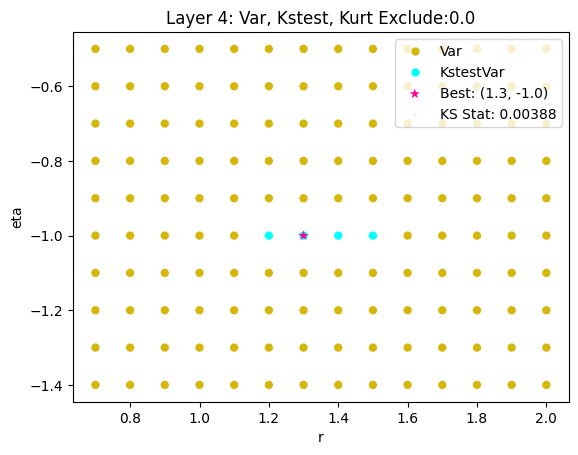

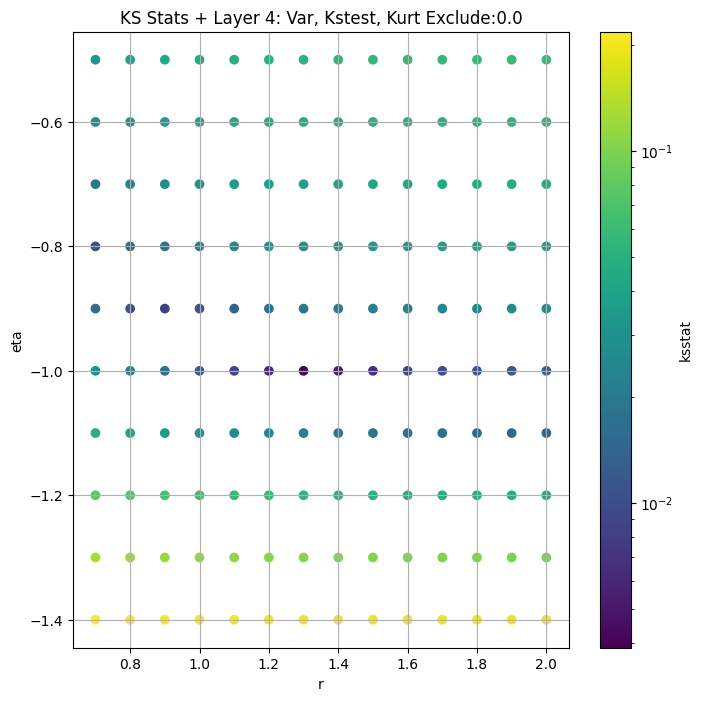

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.004118316987098983 12.390842


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.006118668682808304 11.990485


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.00726735311115323 11.750929


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.006735458716932041 11.553584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.006103955192024196 11.378798


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.006960167621709257 11.075451


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.006860419552589647 10.812894


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.0068117823405270395 10.576421


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.006787888162550049 10.36084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.00676702922236418 10.160164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.008541734095713672 9.632683
Number of samples: 100000, Without approximation : 156544.0


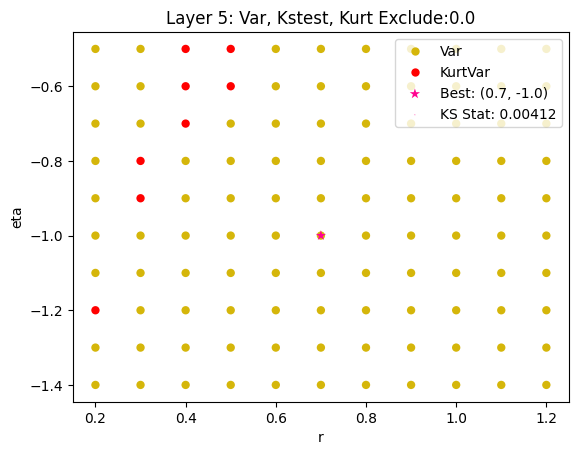

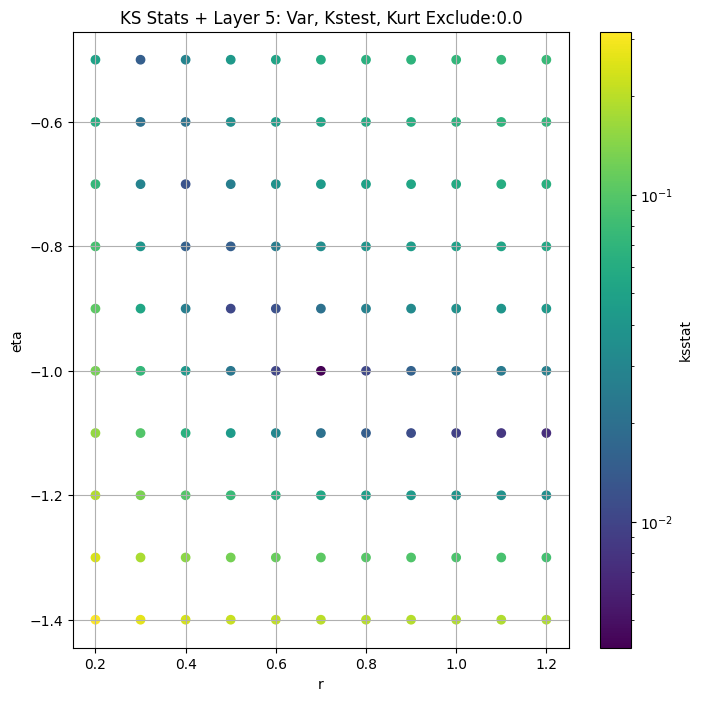

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.011441738818245673 2.4288213


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.011211650838160891 2.3267043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.01101433352519987 2.273115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.010845417468774765 2.228546


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.010694430552843026 2.1896937


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.01066974854437075 2.1224751


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.011303548763416438 2.064299


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.011132469260778821 2.012481


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.010931102607847576 1.9654188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.010739668034359218 1.9220352


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.011109728539833719 1.8081242
Number of samples: 100000, Without approximation : 626176.0


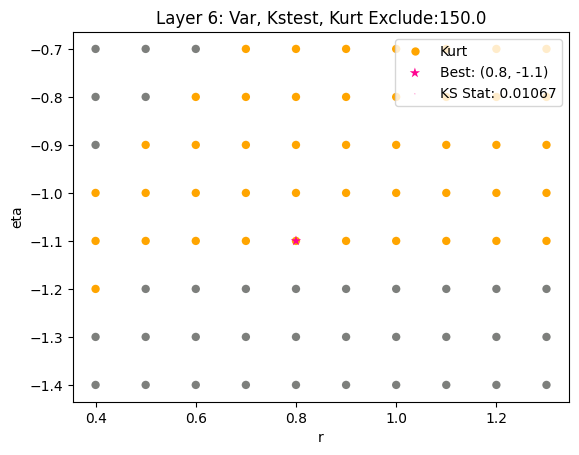

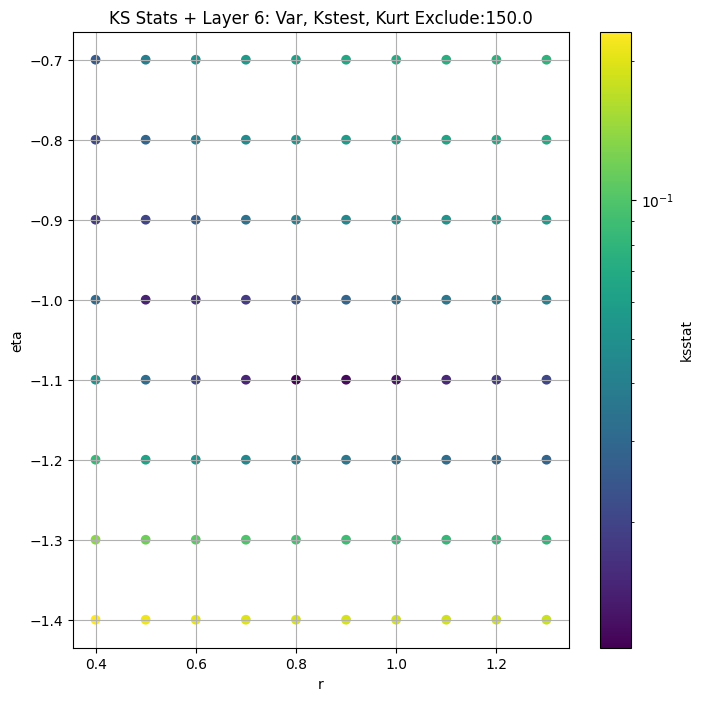

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.012076437632030035 0.5177899


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.012114627055566096 0.48941657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.012296434273914691 0.47691864


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.012419300742587125 0.46662432


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.012113840241933294 0.4576794


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.012432450590765698 0.44226453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.012080717226665594 0.42905545


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.012225148604305902 0.4173387


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.012408720699145004 0.40670115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.0121446259348017 0.39693686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.012269195057641236 0.37153953
Number of samples: 100000, Without approximation : 2504704.0


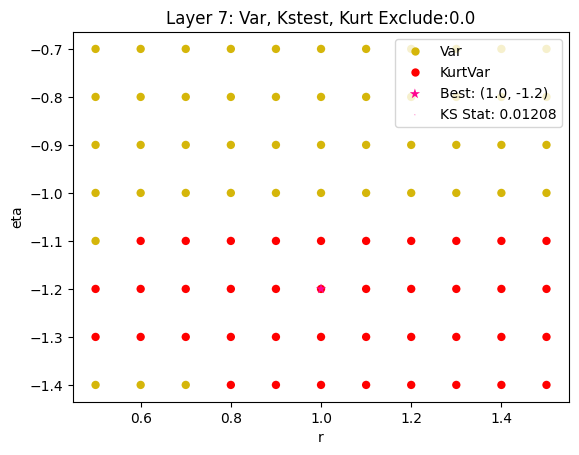

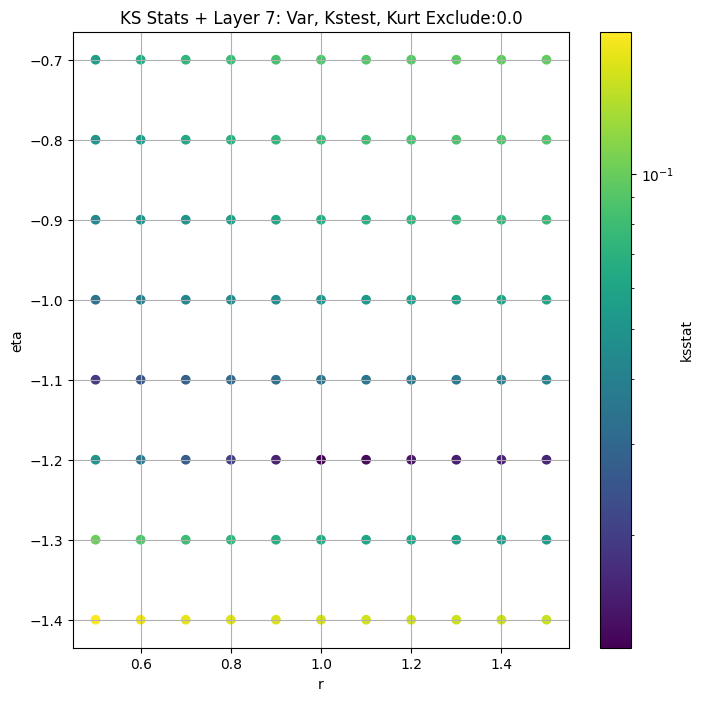

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.010919006844048396 0.15233928


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.009178723947928458 0.14209738


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.008447891392445284 0.13803697


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.007831726438585984 0.13472542


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.007871656766515467 0.13184573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.00974017607468991 0.1269081


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.011334038467308627 0.122693956


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.010955952550463222 0.11896326


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.010850562092221905 0.11559876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.010993272714817343 0.11252139


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010631320135138012 0.10455287
Number of samples: 100000, Without approximation : 10018816.0


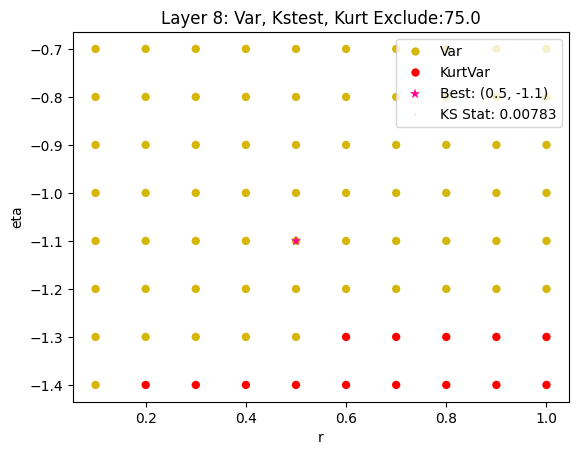

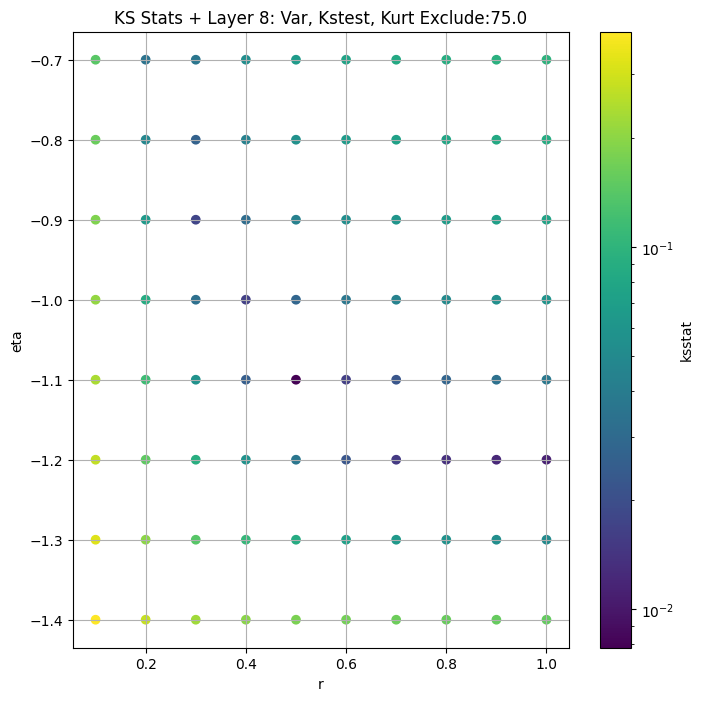

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.020437098349800814 0.046734266


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.020403782448520924 0.04314348


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.018639877605322708 0.04164593


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.01924363372478377 0.040434375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.020301769332712882 0.0393881


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.022174835822798444 0.037605558


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.02249487931654326 0.036097996


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.020642408003296198 0.03477634


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.01892344374661159 0.033592526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.01924755160042191 0.032517705


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.01772195922763342 0.02976548
Number of samples: 100000, Without approximation : 40075264.0


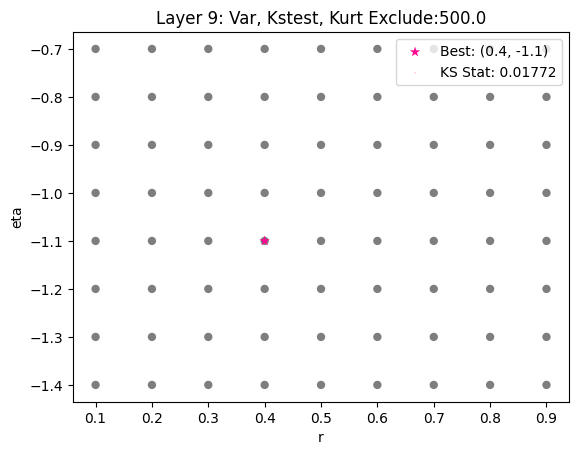

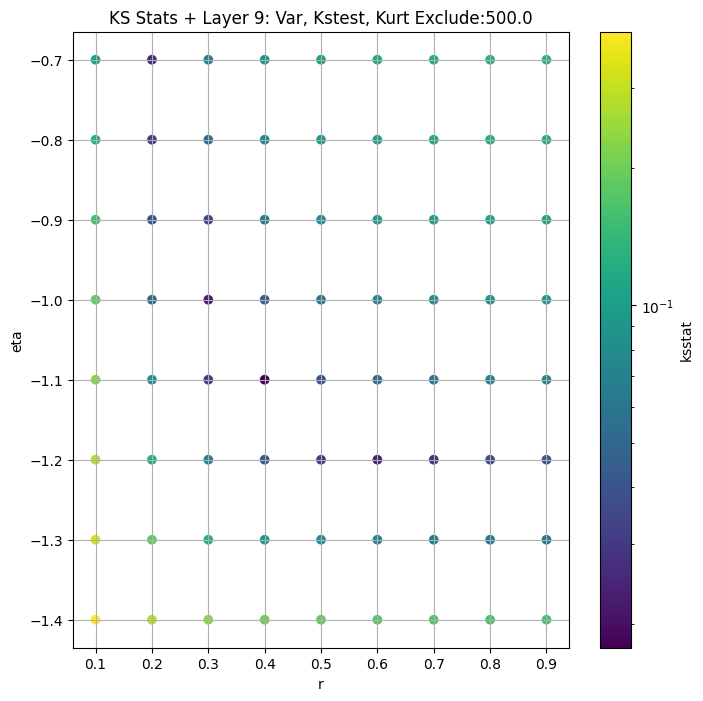

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1270.457600  1168.367300  1376.895000   0.489977    0.119493   
3       299.618200   284.338960   315.560900   1.992060    1.628158   
4        63.174885    58.869780    67.908690   5.602782    3.600154   
5        12.390842    11.438591    13.486277   8.176788    5.416881   
6         2.428821     2.212382     2.730339  13.770252    7.058678   
7         0.517790     0.464621     0.626408  29.275566    8.197229   
8         0.152339     0.134369     0.196486  49.609196    9.834152   
9         0.046734     0.040591     0.059938  54.144787   13.522397   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.913066         2446.0             0.015839        7.3         -0.2   
3        2.431081         9784.0             0.008010       20.0         -0.9   
4        9.362343        39136.0             0.003879        1.3         -1.0   
5       19.982847       156544.0             0.004118        0.7         -1.0   
6       52.622623       626176.0             0.010670        0.8         -1.1   
7      170.895340      2504704.0             0.012076        1.0         -1.2   
8      280.199700     10018816.0             0.007832        0.5         -1.1   
9      272.314400     40075264.0             0.017722        0.4         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        2320.508364                     0.0         1270.457600   
3         818.816126                     0.0          299.618200   
4         156.574315                     0.0           63.174885   
5          14.789118                     0.0           12.390842   
6           4.093290                   150.0            2.122475   
7           1.725966                     0.0            0.517790   
8           0.093559                    75.0            0.134725   
9           0.008956                   500.0            0.029765   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.05929315296300386, var: 804.3261108398438


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.050412279075135014, var: 882.1400146484375


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.04075567602953689, var: 971.8431396484375


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.02960648724675896, var: 1084.4866943359375


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.015839126740195497, var: 1270.4576416015625
Number of samples: 2446, Without approximation : 2446.0


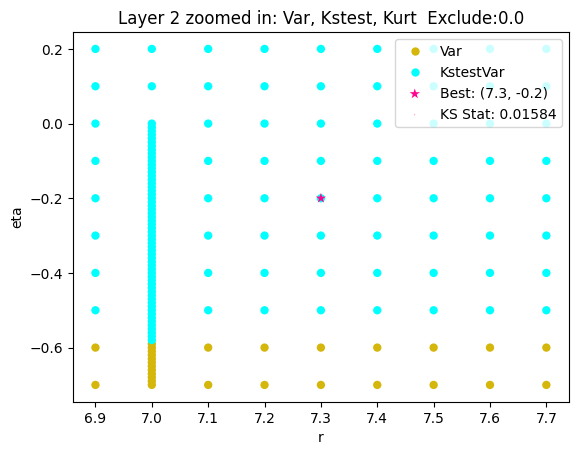

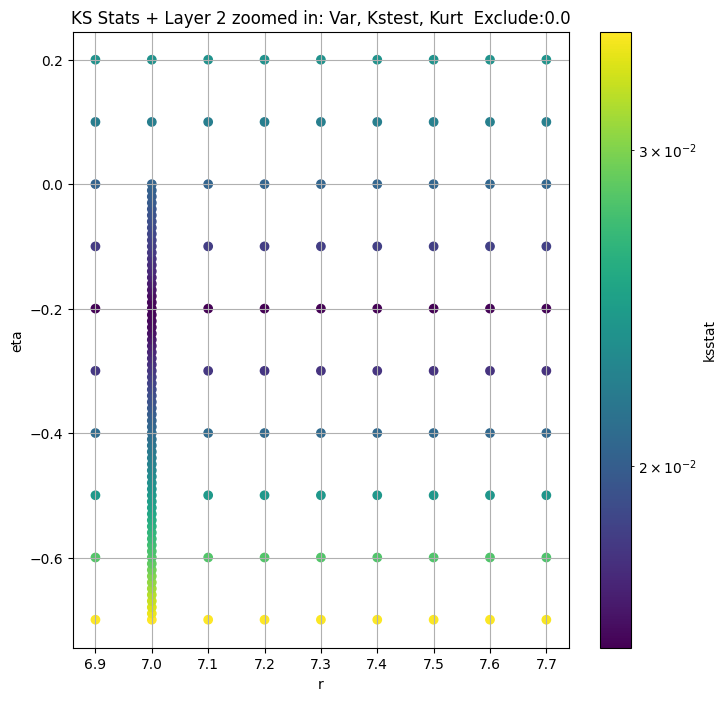

Layer 3


  0%|          | 0/10 [00:00<?, ?it/s]

Finding Minimum after computing 10 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.01763735207210826, var: 237.376953125


  0%|          | 0/10 [00:00<?, ?it/s]

Finding Minimum after computing 10 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.01422321239429325, var: 248.35592651367188


  0%|          | 0/10 [00:00<?, ?it/s]

Finding Minimum after computing 10 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.010907583163122236, var: 261.0926208496094


  0%|          | 0/10 [00:00<?, ?it/s]

Finding Minimum after computing 10 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.011266043641313783, var: 276.49652099609375


  0%|          | 0/10 [00:00<?, ?it/s]

Finding Minimum after computing 10 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.0080098344083544, var: 299.6181945800781
Number of samples: 9784, Without approximation : 9784.0


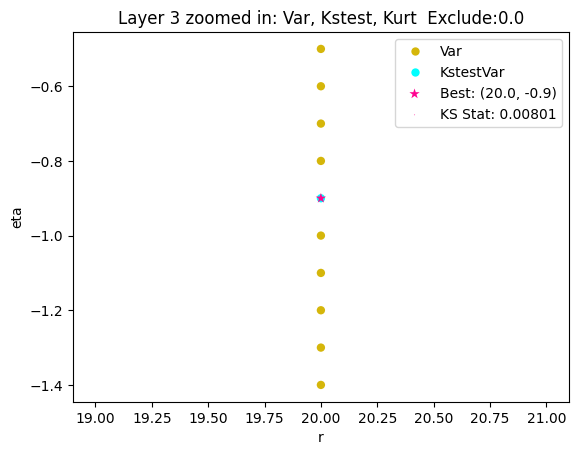

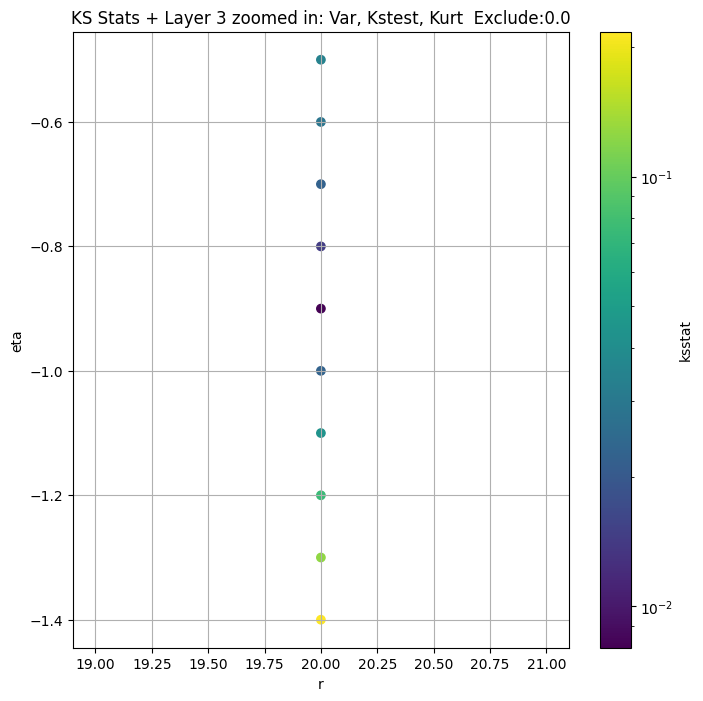

Layer 4


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.007948720227047401, var: 55.26250076293945


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.006685847083733432, var: 56.540924072265625


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.005268404639202751, var: 58.01095199584961


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.00439357200749968, var: 59.846656799316406


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.0034396903371411436, var: 63.17488479614258
Number of samples: 39136, Without approximation : 39136.0


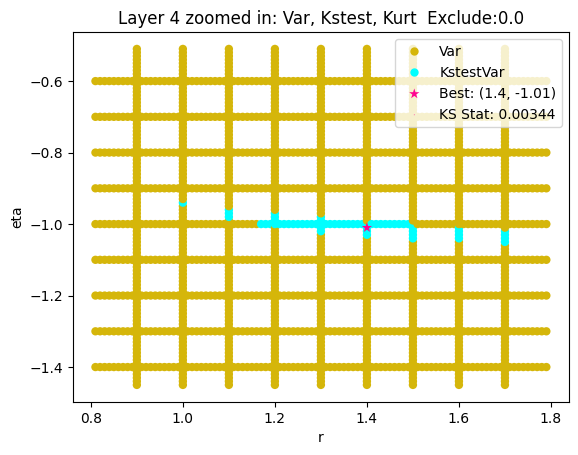

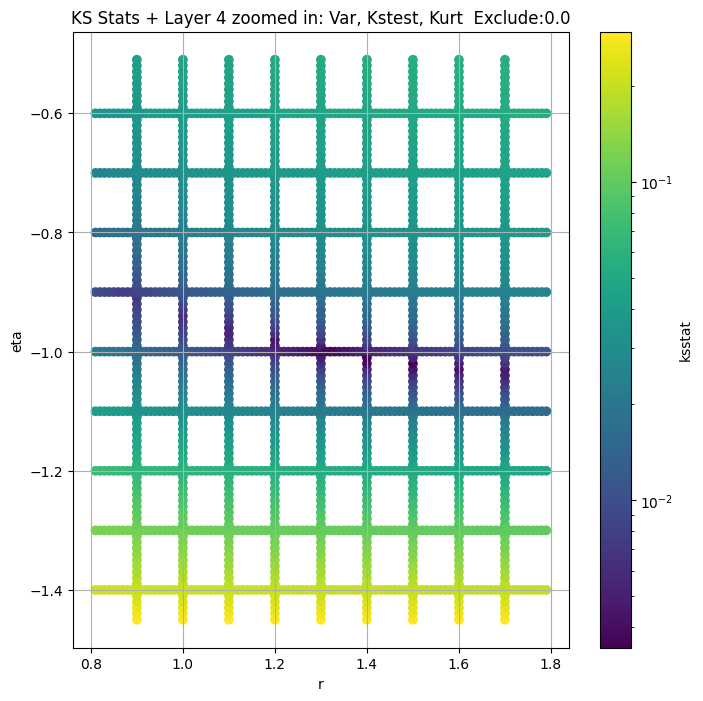

Layer 5


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.004789129343980542, var: 11.37879753112793


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.004615837797293021, var: 11.553584098815918


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.004380858066810989, var: 11.75092887878418


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.00418260715410651, var: 11.990485191345215


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.004118316987098983, var: 12.39084243774414
Number of samples: 100000, Without approximation : 156544.0


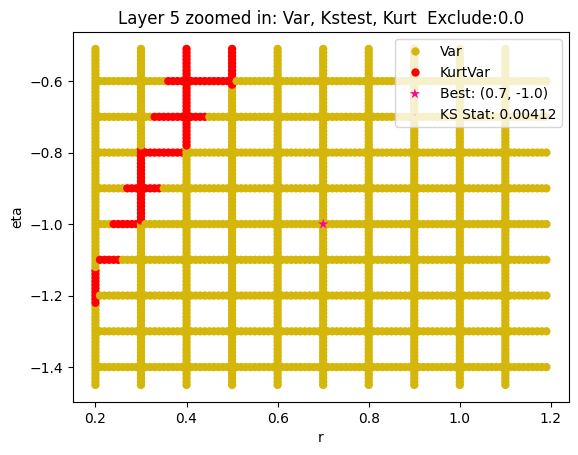

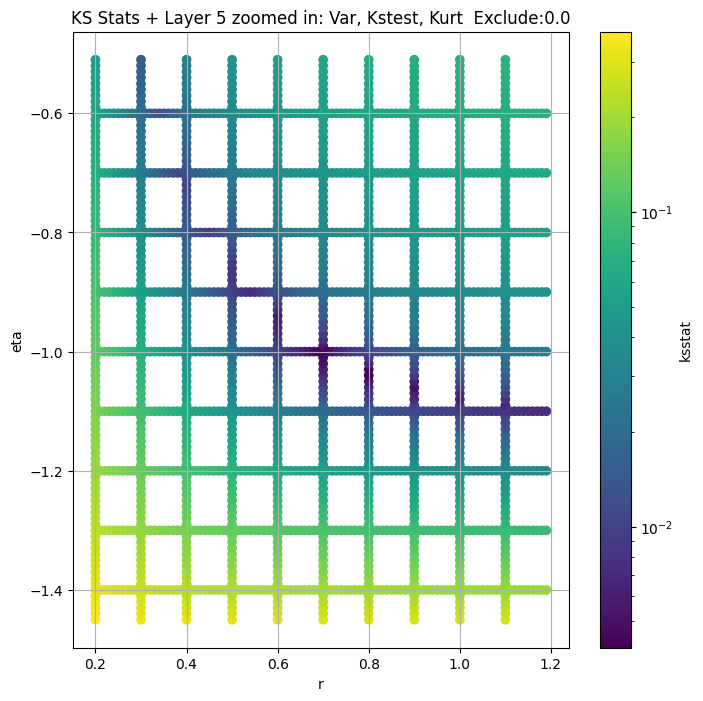

Layer 6


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 150.0 + 100 = 250, ksstat: 0.010197158846370291, var: 2.0124809741973877


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 150.0 + 75 = 225, ksstat: 0.010200335587222886, var: 2.0377070903778076


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 150.0 + 50 = 200, ksstat: 0.009919381409087158, var: 2.0642991065979004


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 150.0 + 25 = 175, ksstat: 0.0097286948320211, var: 2.09242844581604


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 150.0 + 0 = 150, ksstat: 0.010068105934558258, var: 2.1224751472473145


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 150.0 + -25 = 125, ksstat: 0.01007168078018228, var: 2.1547183990478516


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 150.0 + -50 = 100, ksstat: 0.0100197727913926, var: 2.1896936893463135


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 150.0 + -75 = 75, ksstat: 0.010171046905897096, var: 2.228545904159546


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 150.0 + -100 = 50, ksstat: 0.010510575380455911, var: 2.2731149196624756
Number of samples: 100000, Without approximation : 626176.0


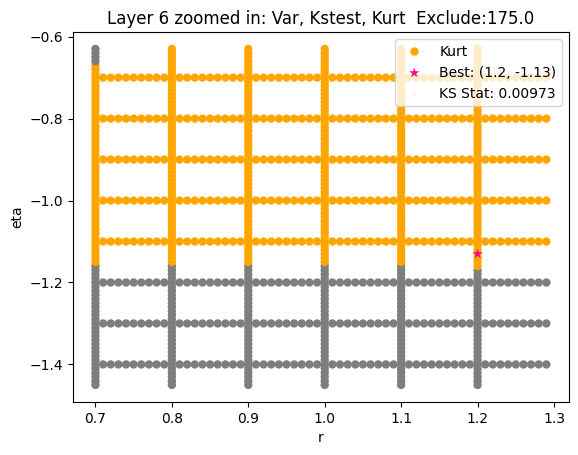

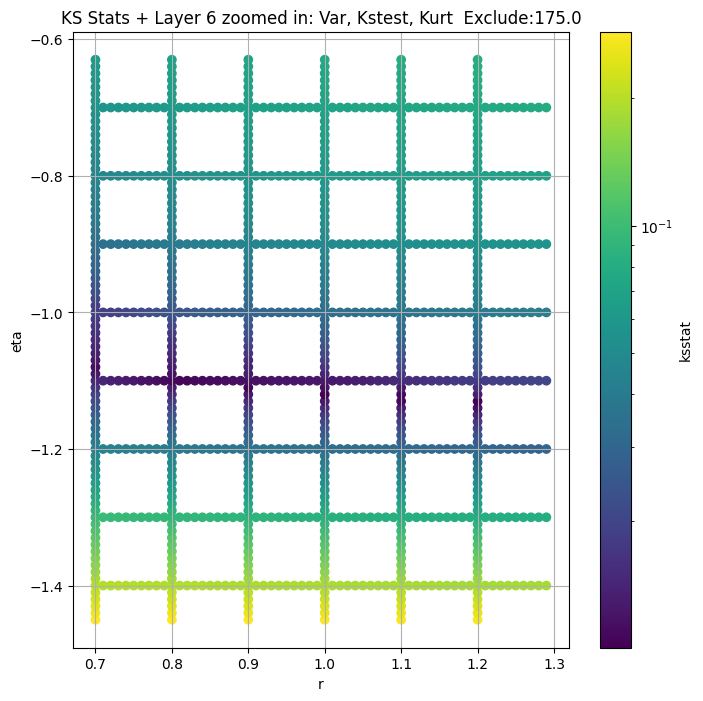

Layer 7


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.011958938850006429, var: 0.4576793909072876


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.011456584226118172, var: 0.46662431955337524


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.011208405091106988, var: 0.47691863775253296


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.011246281738132802, var: 0.48941656947135925


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.011041322191313818, var: 0.517789900302887
Number of samples: 100000, Without approximation : 2504704.0


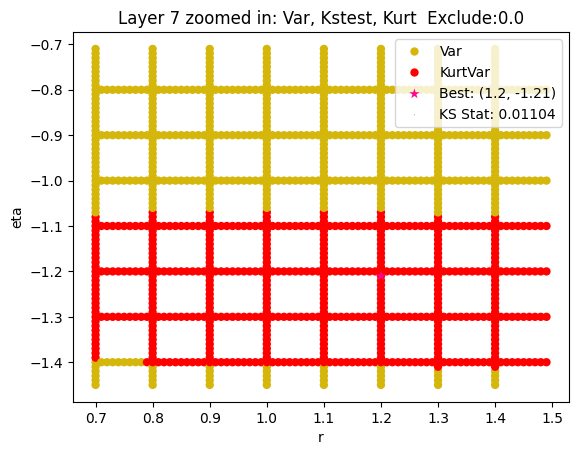

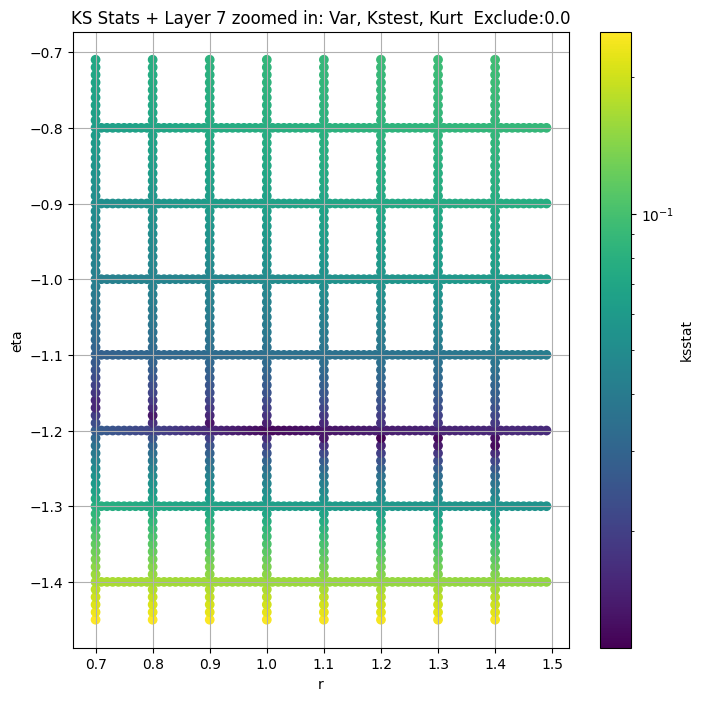

Layer 8


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 75.0 + 100 = 175, ksstat: 0.006997862812165356, var: 0.12473005801439285


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 75.0 + 75 = 150, ksstat: 0.0070517835457678535, var: 0.1269080936908722


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 75.0 + 50 = 125, ksstat: 0.00692338027404249, var: 0.12926383316516876


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 75.0 + 25 = 100, ksstat: 0.006786331408927482, var: 0.13184572756290436


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 75.0 + 0 = 75, ksstat: 0.006637664476743743, var: 0.134725421667099


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 75.0 + -25 = 50, ksstat: 0.0064203620559440955, var: 0.13803696632385254


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 75.0 + -50 = 25, ksstat: 0.006691709940206181, var: 0.1420973837375641


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 75.0 + -75 = 0, ksstat: 0.005866067336842584, var: 0.15233927965164185
Number of samples: 100000, Without approximation : 10018816.0


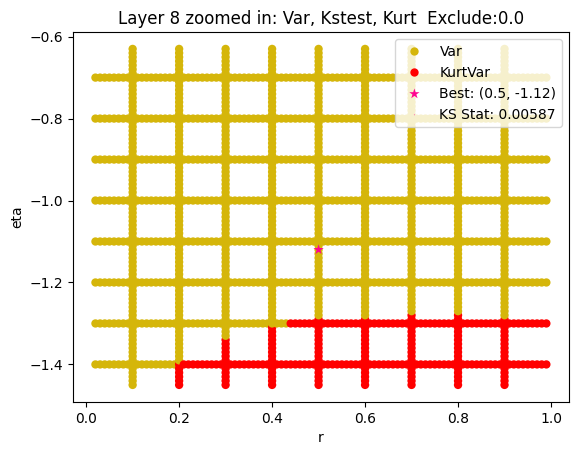

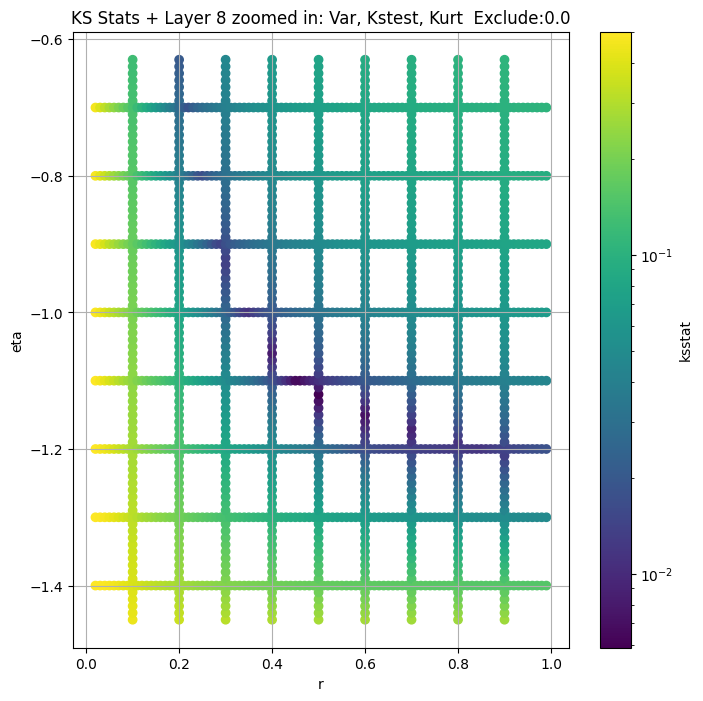

Layer 9


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 500.0 + 100 = 600, ksstat: 0.018976638410616364, var: 0.02821778506040573


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 500.0 + 75 = 575, ksstat: 0.018481276924764978, var: 0.02858726494014263


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 500.0 + 50 = 550, ksstat: 0.018743453226361173, var: 0.02896788716316223


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 500.0 + 25 = 525, ksstat: 0.018223979995198647, var: 0.02936035580933094


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 500.0 + 0 = 500, ksstat: 0.01772195922763342, var: 0.029765479266643524


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 500.0 + -25 = 475, ksstat: 0.017727518597574043, var: 0.030183997005224228


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 500.0 + -50 = 450, ksstat: 0.017177949241534374, var: 0.03061693161725998


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 500.0 + -75 = 425, ksstat: 0.016809243155022746, var: 0.031065570190548897


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 500.0 + -100 = 400, ksstat: 0.017200950197252318, var: 0.031530920416116714
Number of samples: 100000, Without approximation : 40075264.0


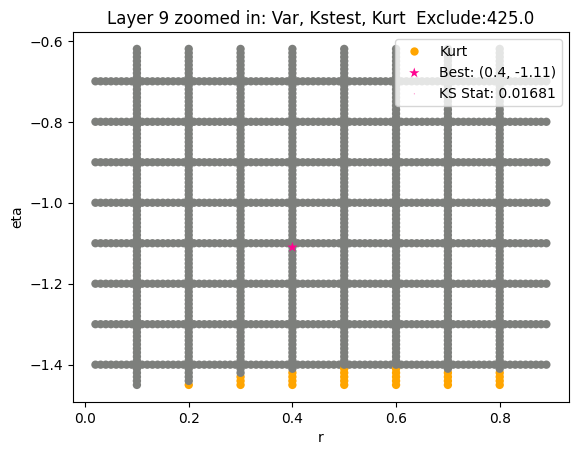

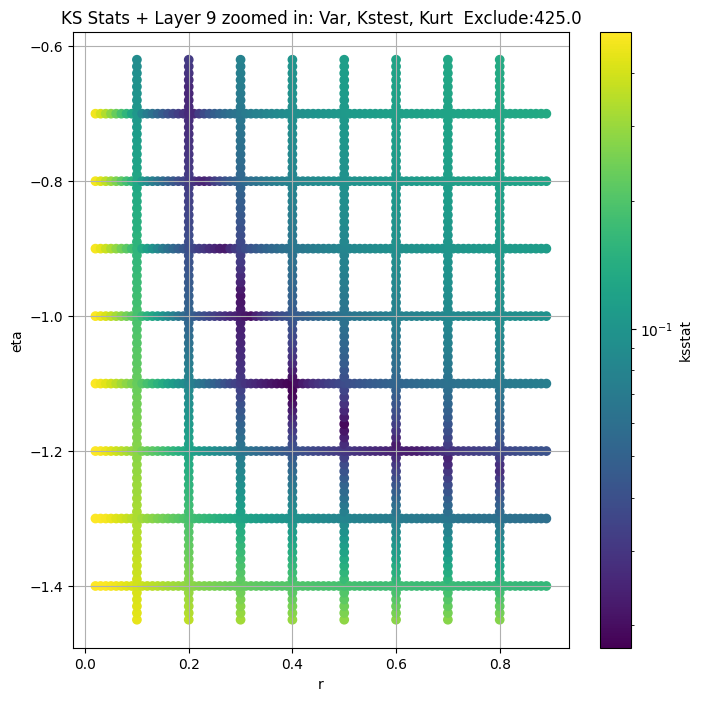

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1270.457600  1168.367300  1376.895000   0.489977    0.119493   
3       299.618200   284.338960   315.560900   1.992060    1.628158   
4        63.174885    58.869780    67.908690   5.602782    3.600154   
5        12.390842    11.438591    13.486277   8.176788    5.416881   
6         2.428821     2.212382     2.730339  13.770252    7.058678   
7         0.517790     0.464621     0.626408  29.275566    8.197229   
8         0.152339     0.134369     0.196486  49.609196    9.834152   
9         0.046734     0.040591     0.059938  54.144787   13.522397   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.913066         2446.0             0.015839        7.3         -0.2   
3        2.431081         9784.0             0.008010       20.0         -0.9   
4        9.362343        39136.0             0.003879        1.3         -1.0   
5       19.982847       156544.0             0.004118        0.7         -1.0   
6       52.622623       626176.0             0.010670        0.8         -1.1   
7      170.895340      2504704.0             0.012076        1.0         -1.2   
8      280.199700     10018816.0             0.007832        0.5         -1.1   
9      272.314400     40075264.0             0.017722        0.4         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        2320.508364                     0.0         1270.457600   
3         818.816126                     0.0          299.618200   
4         156.574315                     0.0           63.174885   
5          14.789118                     0.0           12.390842   
6           4.093290                   150.0            2.092428   
7           1.725966                     0.0            0.517790   
8           0.093559                    75.0            0.152339   
9           0.008956                   500.0            0.031066   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.015839     7.3     -0.20   
3                     0.013713          0.008010    20.0     -0.90   
4                     0.006861          0.003440     1.4     -1.01   
5                     0.003431          0.004118     0.7     -1.00   
6                     0.001716          0.009729     1.2     -1.13   
7                     0.000858          0.011041     1.2     -1.21   
8                     0.000429          0.005866     0.5     -1.12   
9                     0.000215          0.016809     0.4     -1.11   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      2320.508364                  0.0         7432  
3       818.816126                  0.0        27859  
4       166.383914                  0.0       148594  
5        14.789118                  0.0       111445  
6         6.499078                175.0        19568  
7         2.022838                  0.0        14676  
8         0.113890                  0.0        55722  
9         0.009753                425.0         6190

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

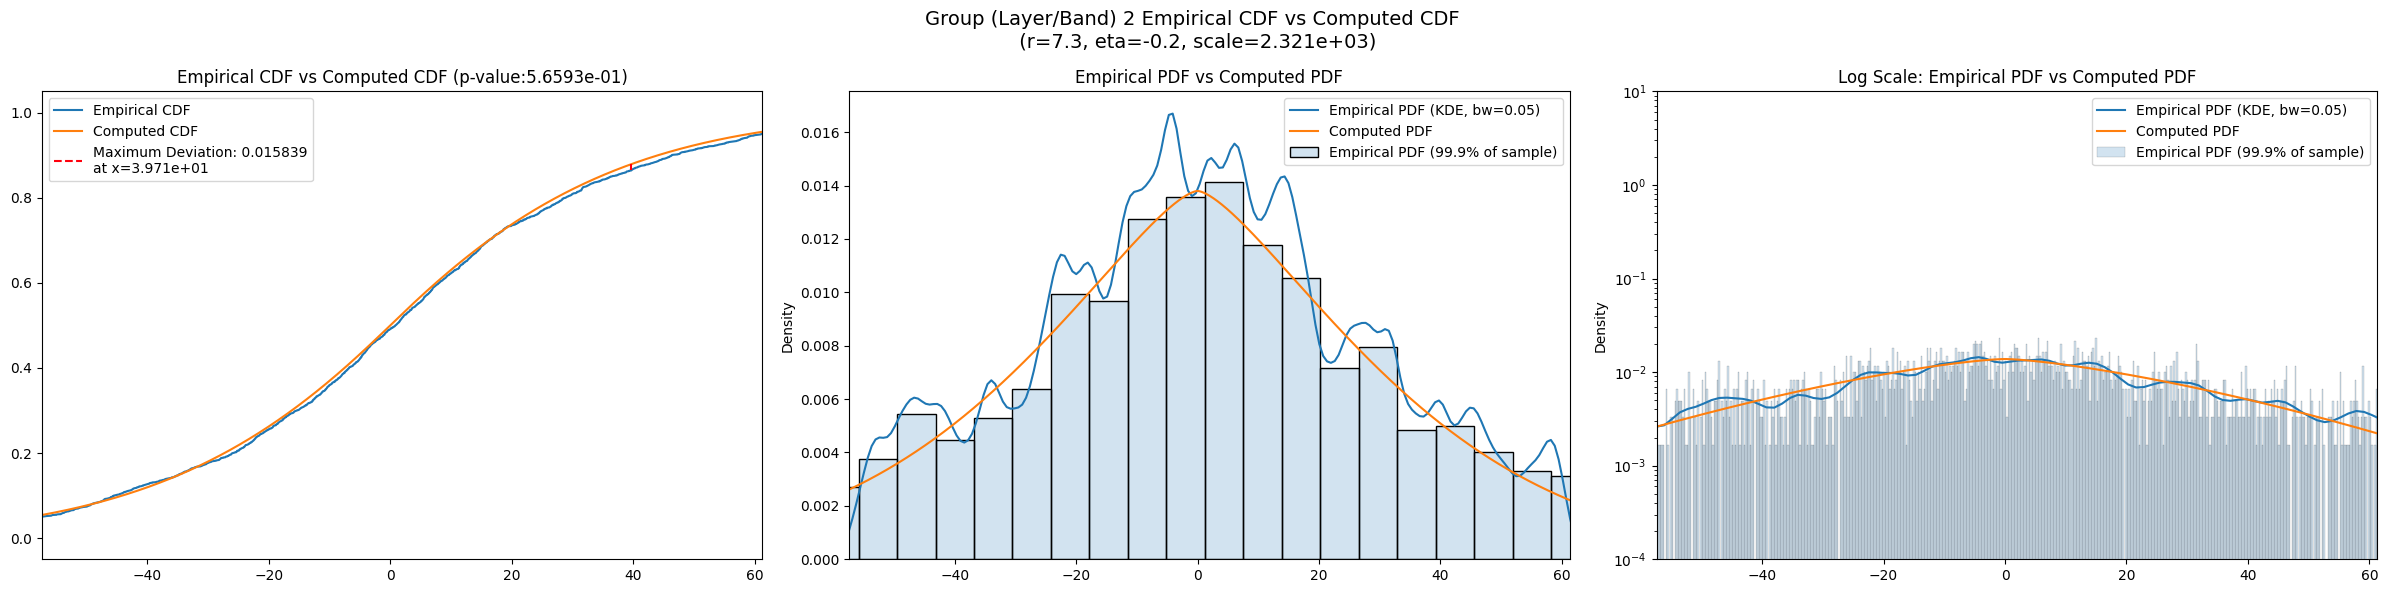

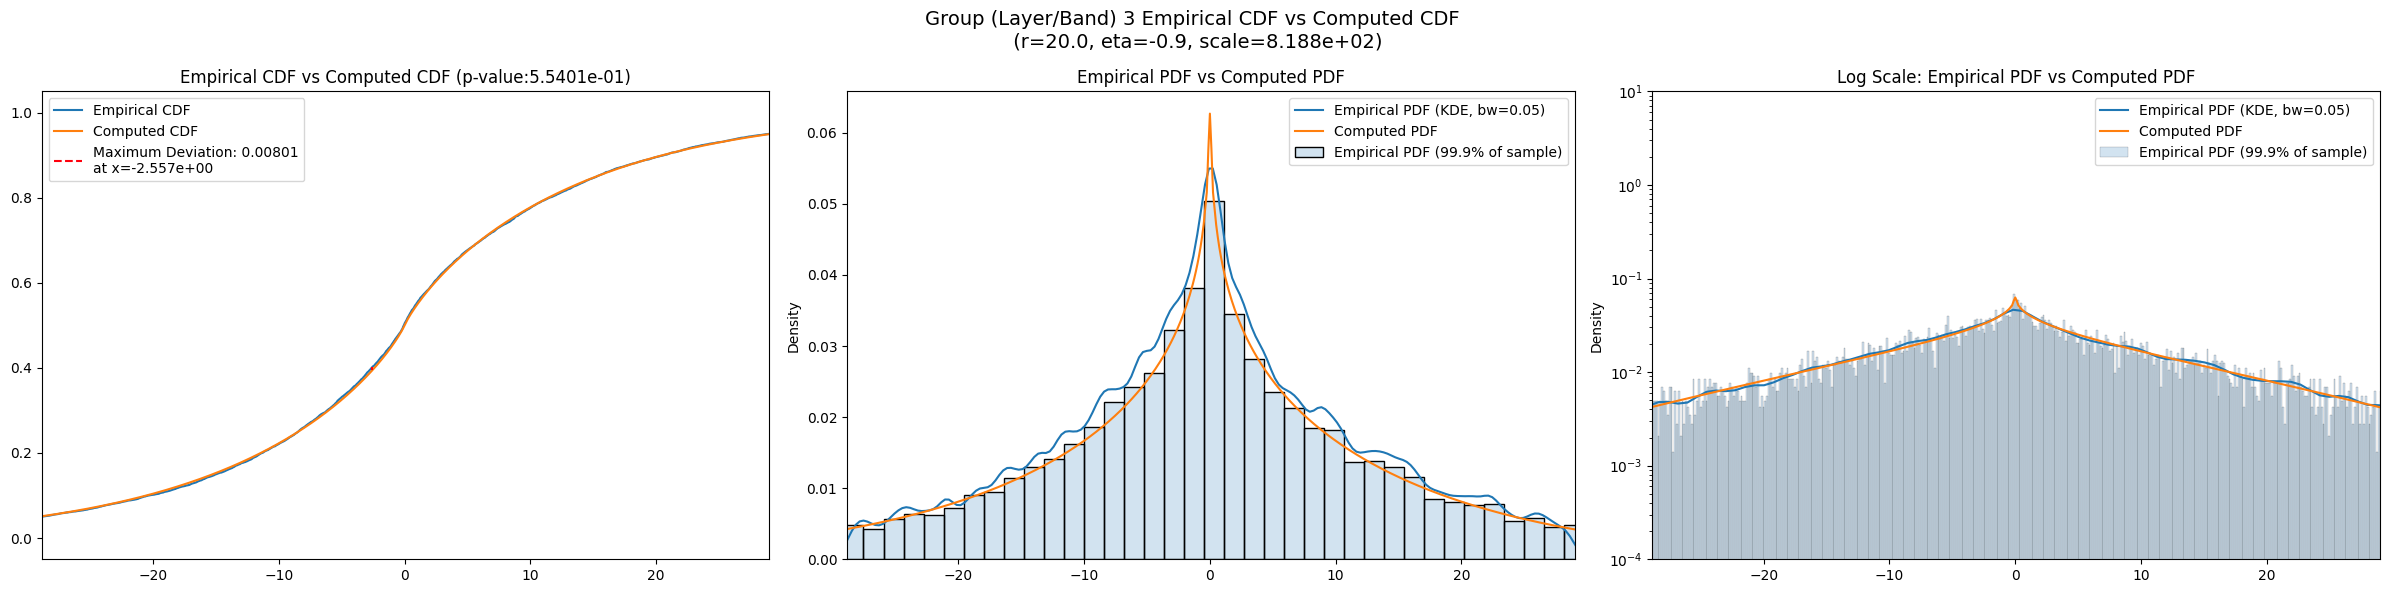

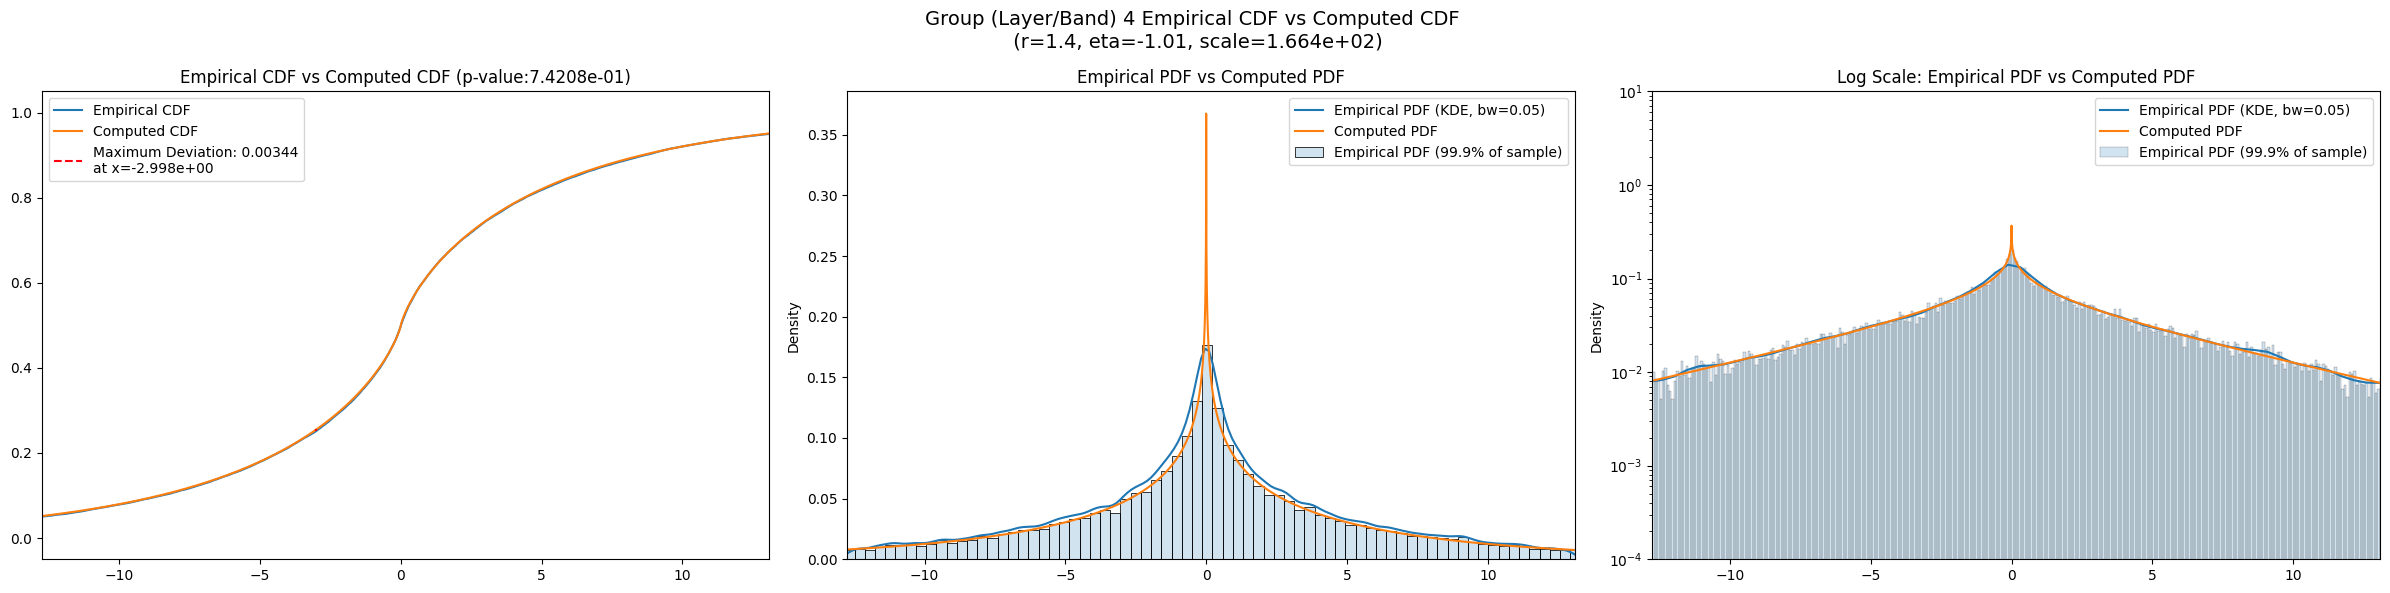

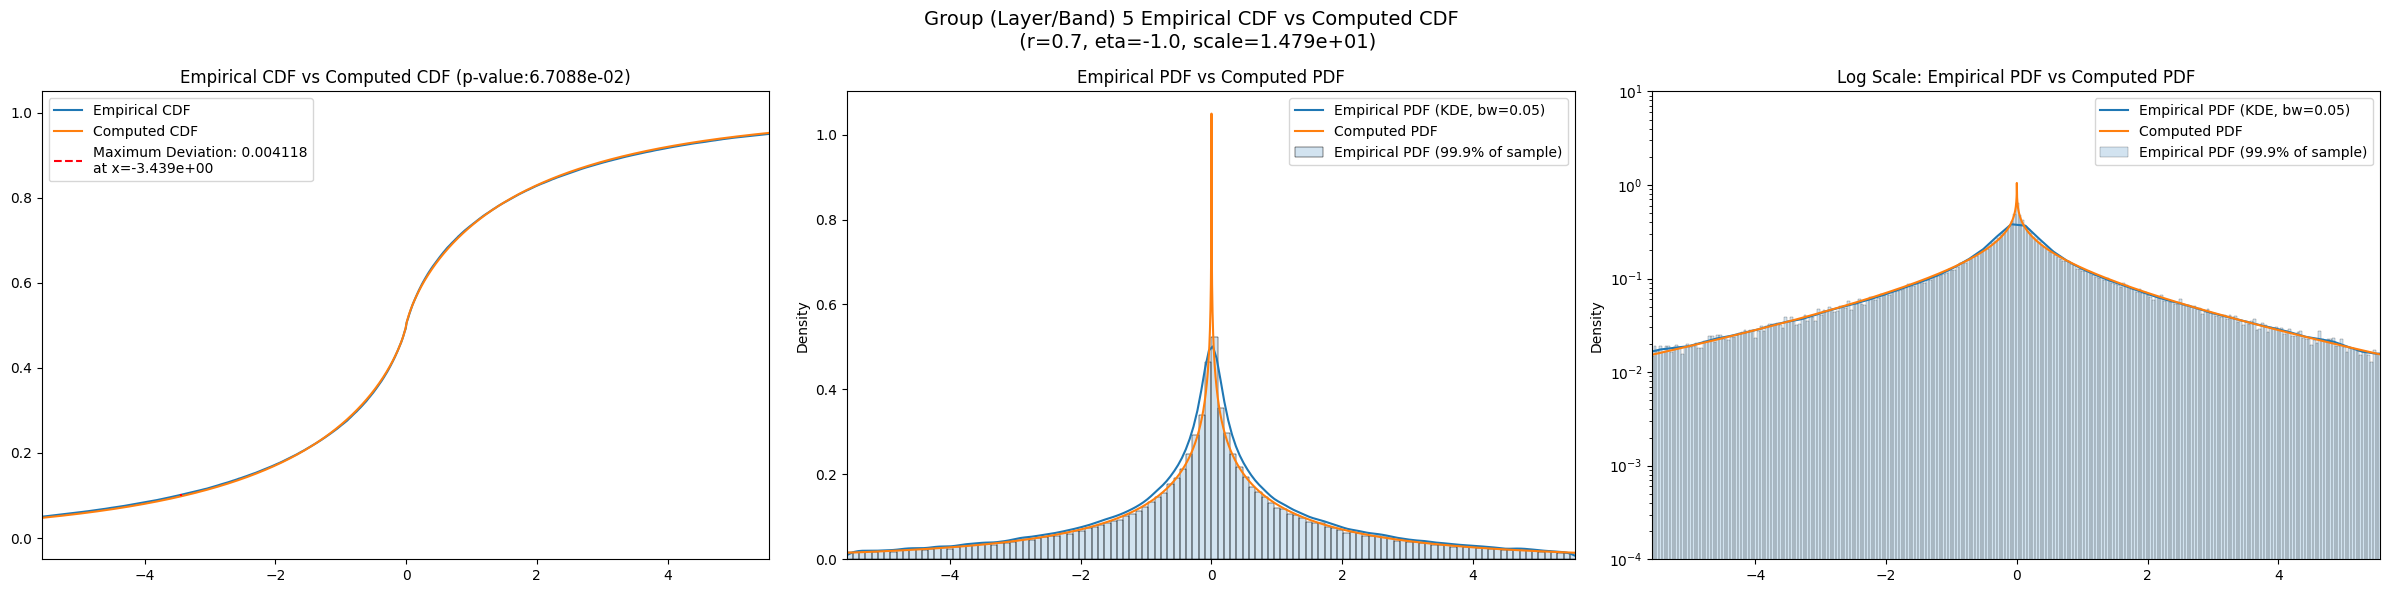

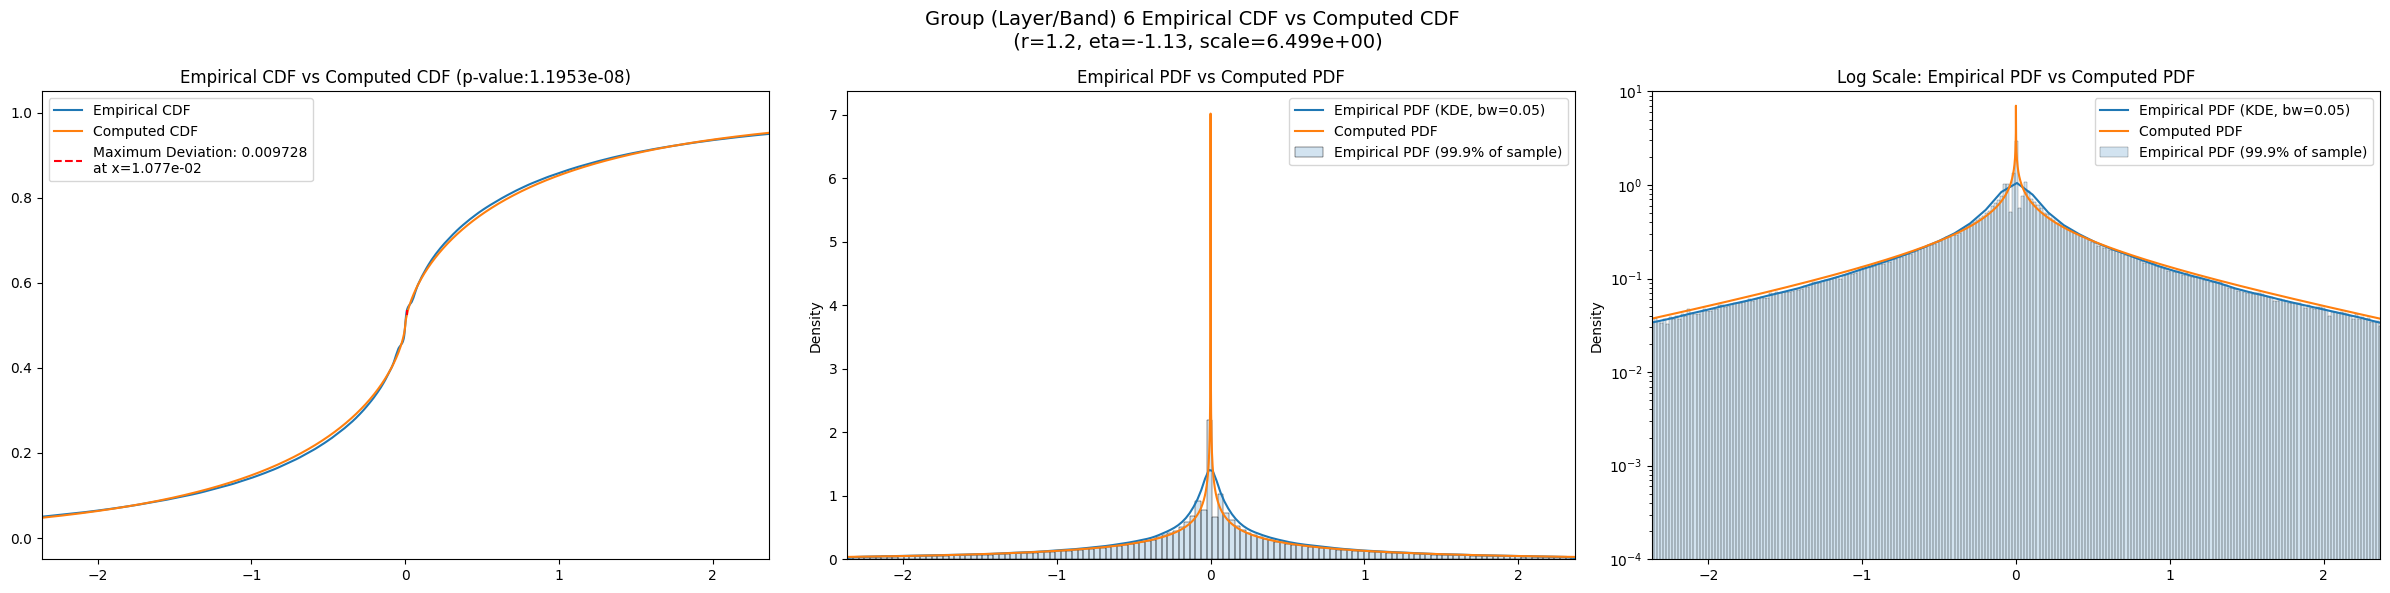

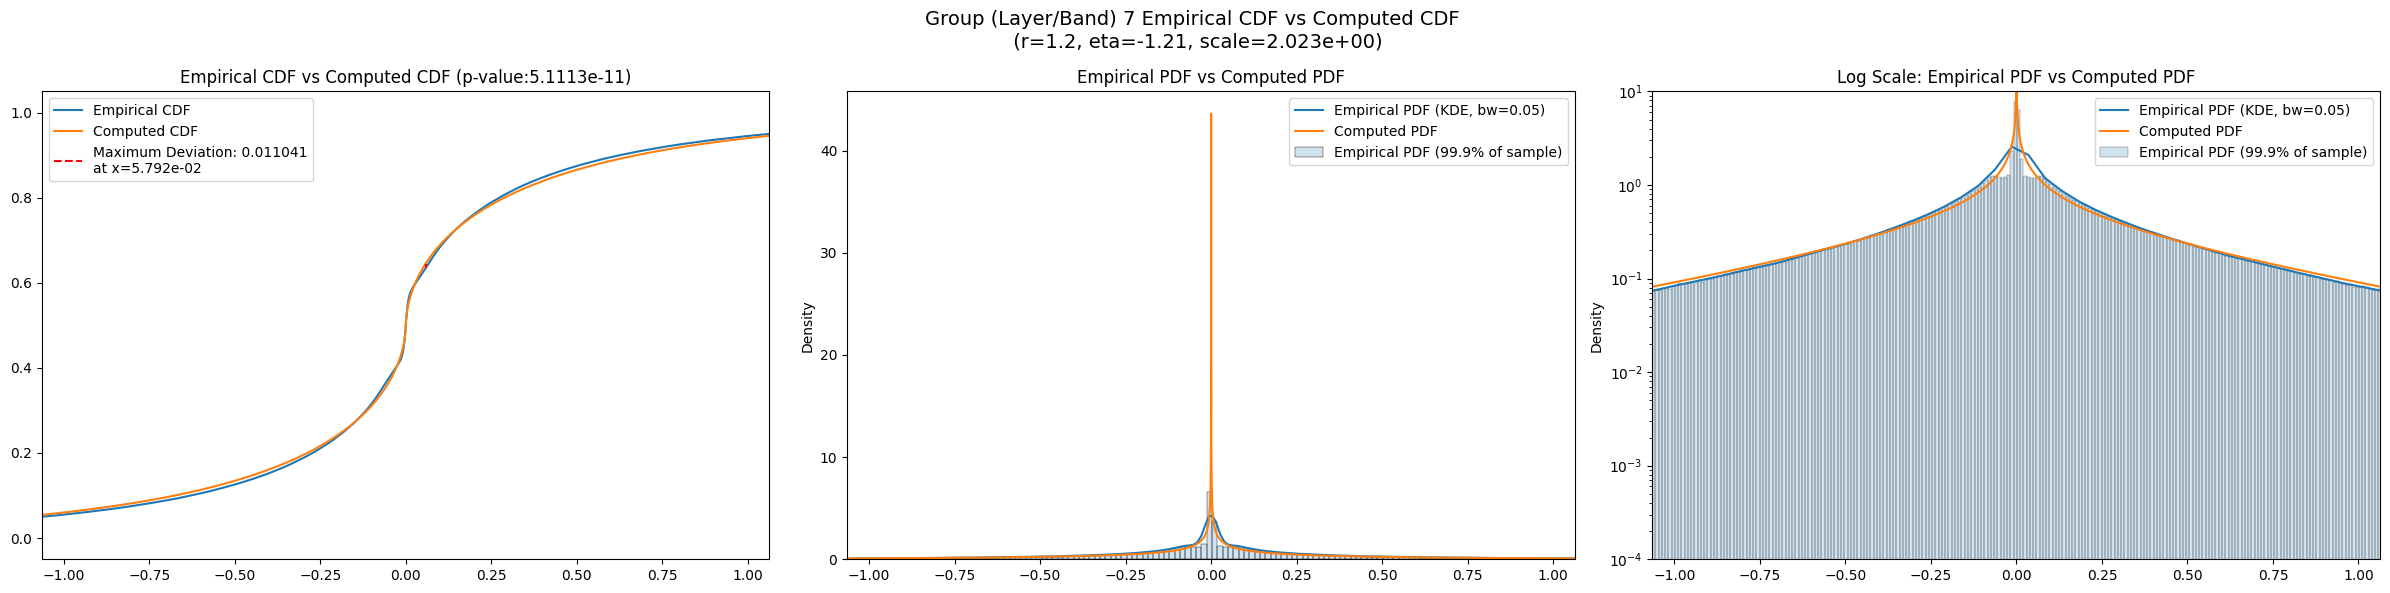

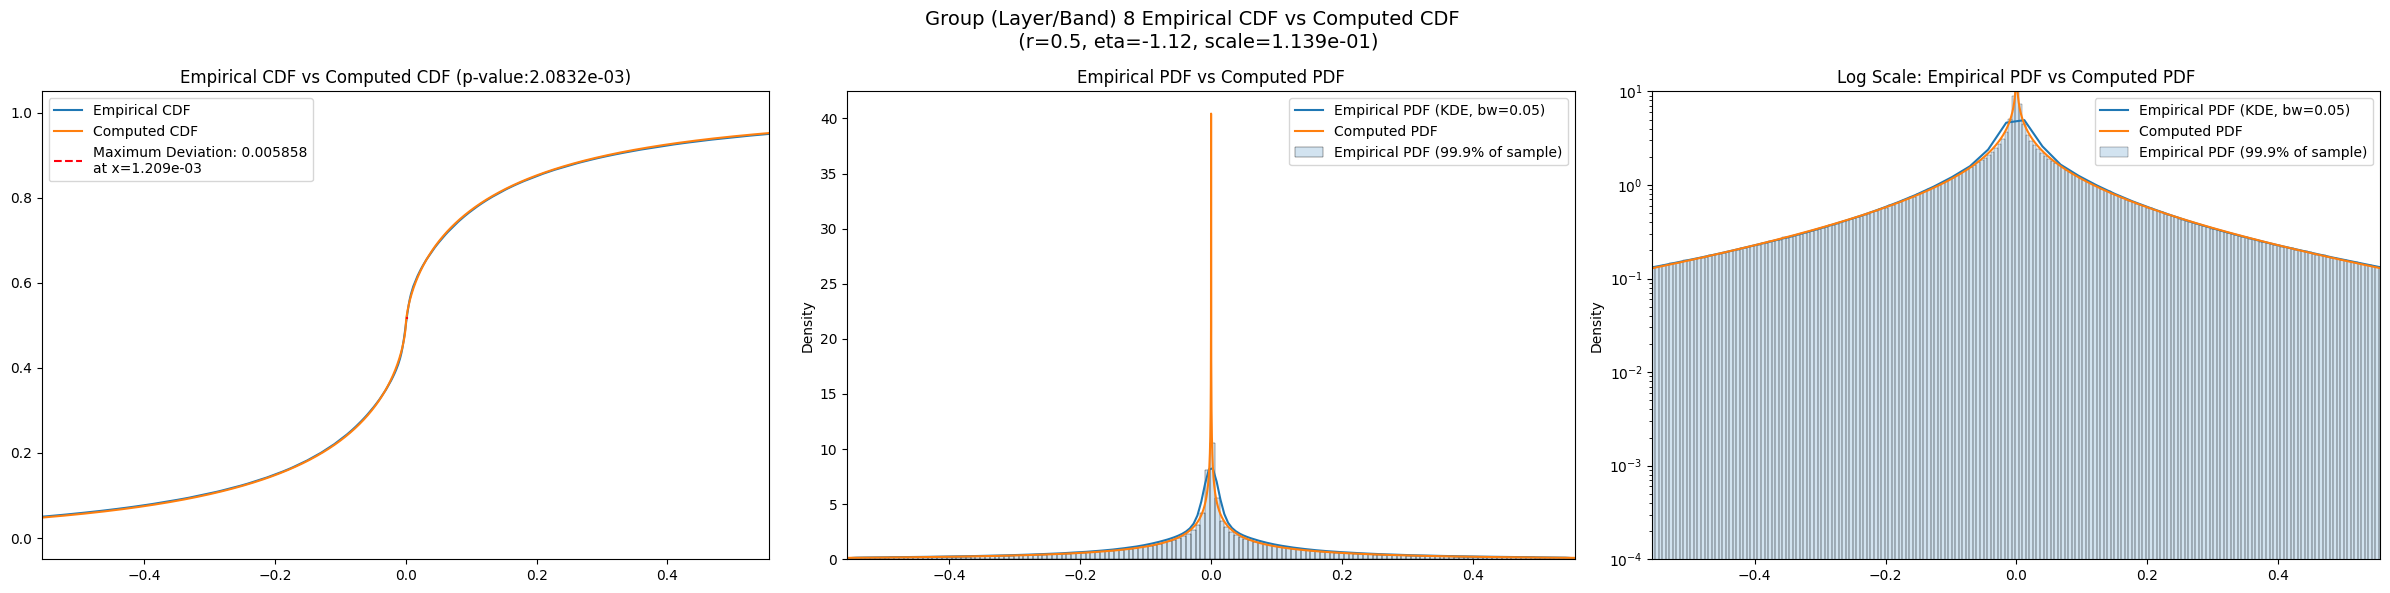

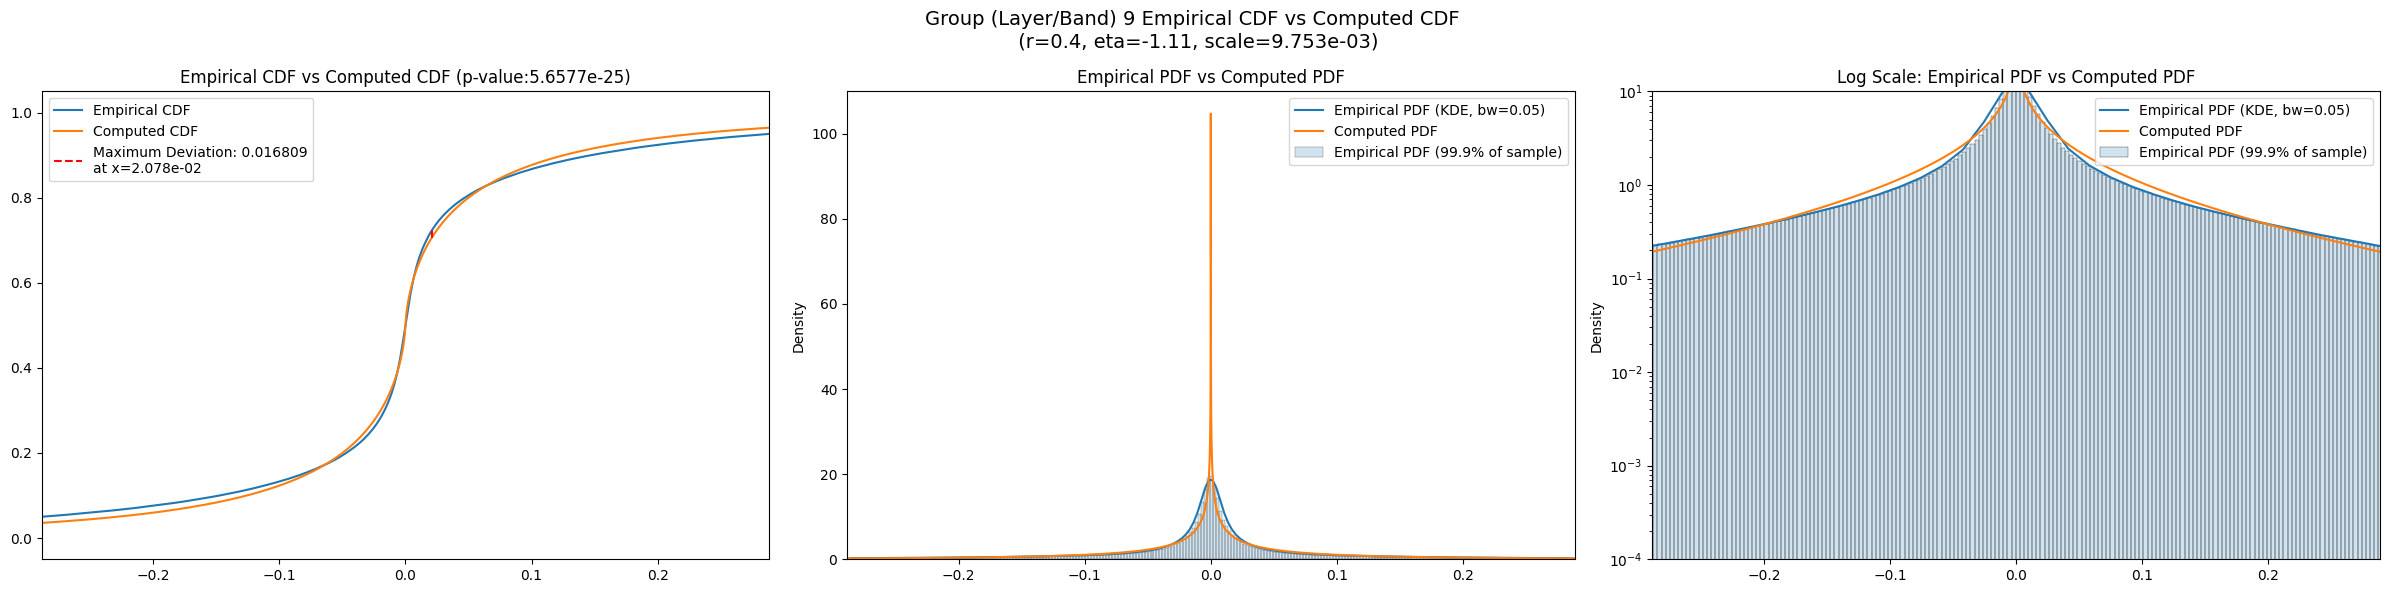

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1270.457600  1168.367300  1376.895000   0.489977    0.119493   
3       299.618200   284.338960   315.560900   1.992060    1.628158   
4        63.174885    58.869780    67.908690   5.602782    3.600154   
5        12.390842    11.438591    13.486277   8.176788    5.416881   
6         2.428821     2.212382     2.730339  13.770252    7.058678   
7         0.517790     0.464621     0.626408  29.275566    8.197229   
8         0.152339     0.134369     0.196486  49.609196    9.834152   
9         0.046734     0.040591     0.059938  54.144787   13.522397   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.913066         2446.0             0.015839        7.3         -0.2   
3        2.431081         9784.0             0.008010       20.0         -0.9   
4        9.362343        39136.0             0.003879        1.3         -1.0   
5       19.982847       156544.0             0.004118        0.7         -1.0   
6       52.622623       626176.0             0.010670        0.8         -1.1   
7      170.895340      2504704.0             0.012076        1.0         -1.2   
8      280.199700     10018816.0             0.007832        0.5         -1.1   
9      272.314400     40075264.0             0.017722        0.4         -1.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       32.879800              0.027166          5.310530e-02   
3      ...       13.706800              0.036699          6.948080e-12   
4      ...        5.296290              0.050739          5.267010e-88   
5      ...        2.023300              0.060377          0.000000e+00   
6      ...        0.781990              0.067150          0.000000e+00   
7      ...        0.340185              0.069107          0.000000e+00   
8      ...        0.159759              0.076166          0.000000e+00   
9      ...        0.061500              0.093621          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          29.483700             0.025606         7.953060e-02  24.111700   
3          11.879000             0.014246         3.732970e-02   9.990250   
4           4.577570             0.025552         1.247690e-22   3.734430   
5           1.742220             0.034141        5.788750e-159   1.387990   
6           0.671444             0.041326         0.000000e+00   0.531298   
7           0.266514             0.053011         0.000000e+00   0.211421   
8           0.133953             0.053195         0.000000e+00   0.104048   
9           0.053739             0.068346         0.000000e+00   0.041279   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.029788   2.552520e-02          5.659260e-01  
3           0.020175   6.853780e-04          5.539936e-01  
4           0.030821   9.859320e-33          7.420845e-01  
5           0.037409  8.933620e-191          9.855252e-03  
6           0.043904   0.000000e+00          6.597198e-52  
7           0.055413   0.000000e+00         1.185211e-265  
8           0.055357   0.000000e+00         7.063207e-300  
9           0.067190   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.015839                 0.027391          0.015839   
3                 0.008010                 0.013713          0.008010   
4                 0.003879                 0.006861          0.003440   
5                 0.004118                 0.003431          0.004118   
6                 0.010670                 0.001716          0.009729   
7                 0.012076                 0.000858          0.011041   
8                 0.007832                 0.000429          0.005866   
9                 0.017722                 0.000215          0.016809   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.027166             0.025606       0.029788  
3                  0.036699             0.014246       0.020175  
4                  0.050739             0.025552       0.030821  
5                  0.060377             0.034141       0.037409  
6                  0.067150             0.041326       0.043904  
7                  0.069107             0.053011       0.055413  
8                  0.076166             0.053195       0.055357  
9                  0.093621             0.068346       0.067190

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             1270.457600          0.015839     7.3     -0.20  2320.508364   
3              299.618200          0.008010    20.0     -0.90   818.816126   
4               63.174885          0.003440     1.4     -1.01   166.383914   
5               12.390842          0.004118     0.7     -1.00    14.789118   
6                2.092428          0.009729     1.2     -1.13     6.499078   
7                0.517790          0.011041     1.2     -1.21     2.022838   
8                0.152339          0.005866     0.5     -1.12     0.113890   
9                0.031066          0.016809     0.4     -1.11     0.009753   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                    175.0  
7                      0.0  
8                      0.0  
9                    425.0

In [21]:
eng.quit()